### Install and import packages

In [ ]:
# Install packages
!pip install bayes_logistic

In [1]:
# Import packages
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

color_list = ["Green", "Blue"]
color_map = mcolors.ListedColormap(["Green", "Blue"])

import seaborn as sns
sns.set()
sns.set_palette("tab10")

import random as rnd
import numpy as np
rnd.seed(0)
np.random.seed(0)

import scipy.stats as stats
import bayes_logistic

### Set parameters

In [2]:
# Set parameters
# num_data
num_data = 100
num_data_half = num_data // 2
num_feats = 2

# num_samples 
num_samples = 1000

# data_x marginal distribution parameters
data_x_marginal_params = [
    [[1.0, 5.0], [(1.0, 0.0), (0.0, 1.0)]],
    [[-5.0, 1.0], [(3.0, 0.0), (0.0, 3.0)]]]

# weights prior distribution parameters
weights_prior_params = [[0.0, 0.0], [[1.0, 0.0], [0.0, 1.0]]]

# init sigma used in numerical optimization for laplace approximation
laplace_init_sigma = 0.01
laplace_num_iters = 1000


### Generate data_x

$$
\begin{align*}
  \mathrm{data}\_x &= [c_0\_x, c_1\_x]\\
  c_0\_x &\sim p(x|\mu_0, \sigma_0^2) \\
  c_1\_x &\sim p(x|\mu_1, \sigma_1^2)
\end{align*}
$$


In [3]:
# Generate data_x
data_x_marginal_dists = [
    stats.multivariate_normal(mu, sigma, seed=12345) \
        for mu, sigma in data_x_marginal_params]

c0_x = data_x_marginal_dists[0].rvs(size=(num_data_half))
c1_x = data_x_marginal_dists[1].rvs(size=(num_data_half))
data_x = np.vstack((c0_x, c1_x))

In [7]:
print(data_x.shape)

(100, 2)


### Sample weights, generate sample y from sample weights and visualize data

#### Comments on the plots
1. Even though the data_x is set to be linearly separable, using random prior weights can lead to linearly nonseparable cases.

### Generate prior and posterior samples

Generate two set of prior samples A and B

$$
\begin{align*}
    & A = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta) \\
    & B = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta)
\end{align*}
$$

Generate a set of posterior from prior samples A

Notes: 
- $x$ is fixed and generated from the above procedure. Only $y_i$ is generated from $\theta_i$.

$$
\begin{align*}
    & C' = \{ \theta_i' \}_{i=1}^N, \\
    & \theta_i' \sim p(\theta|x, y_i), \\
    & y_i \sim p(y_i|x, \theta_i), \; \theta_i \in A
\end{align*}
$$

In [11]:
### Generate prior and posterior samples

# weights' prior distribution
weights_prior_dist_a = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=1)
weights_prior_dist_b = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=11)


samples_a_weights_prior = []
samples_b_weights_prior = []
samples_a_y = []
samples_a_x = []
samples_a_weights_posterior = []
for i in range(num_samples):
    # sample two set of weights' priors 
    sample_a_weights_prior = weights_prior_dist_a.rvs(1)[None,:]
    sample_b_weights_prior = weights_prior_dist_b.rvs(1)[None,:]
    samples_a_weights_prior.append(sample_a_weights_prior)
    samples_b_weights_prior.append(sample_b_weights_prior)
    # print(sample_a_weights_prior.shape)
    # print(sample_b_weights_prior.shape)
    
    sample_c0_x = data_x_marginal_dists[0].rvs(size=(num_data_half))
    sample_c1_x = data_x_marginal_dists[1].rvs(size=(num_data_half))
    sample_a_x = np.vstack((sample_c0_x, sample_c1_x))
    samples_a_x.append(sample_a_x)

    # generate sample y_i from theta_i in A
    sample_a_logit = 1.0 / (1 + np.exp(-np.matmul(sample_a_x, sample_a_weights_prior.T)))
    sample_a_y = stats.bernoulli.rvs(sample_a_logit)
    # print(sample_a_y.shape)
    # stop
    samples_a_y.append(sample_a_y)
    
    
samples_a_weights_prior = np.vstack(samples_a_weights_prior)
samples_b_weights_prior = np.vstack(samples_b_weights_prior)
print(samples_a_weights_prior.shape)
print(samples_b_weights_prior.shape)

samples_a_y = np.vstack(samples_a_y)
samples_a_x = np.vstack(samples_a_x)
print(samples_a_y.shape)
print(samples_a_x.shape)

# fit laplace approximation
w_map, h_map = bayes_logistic.fit_bayes_logistic(
    y = samples_a_y.squeeze(-1),
    X = samples_a_x, 
    wprior = np.zeros(num_feats),
    H = ((np.identity(num_feats)) * 10),
    weights = None,
    solver = "Newton-CG",
    bounds = None,
    maxiter = laplace_num_iters
)
cov_map = np.linalg.inv(h_map)

# sample weights' posterior
samples_a_weights_posterior = stats.multivariate_normal.rvs(w_map, cov_map, size=(num_samples))
print(samples_a_weights_posterior.shape)
print(w_map)
print(cov_map)

(1000, 2)
(1000, 2)
(100000, 1)
(100000, 2)
(1000, 2)
[0.01448494 0.00577158]
[[2.67460982e-06 5.39868739e-09]
 [5.39868739e-09 2.66088775e-06]]


### Visualize the generated prior and posterior samples 

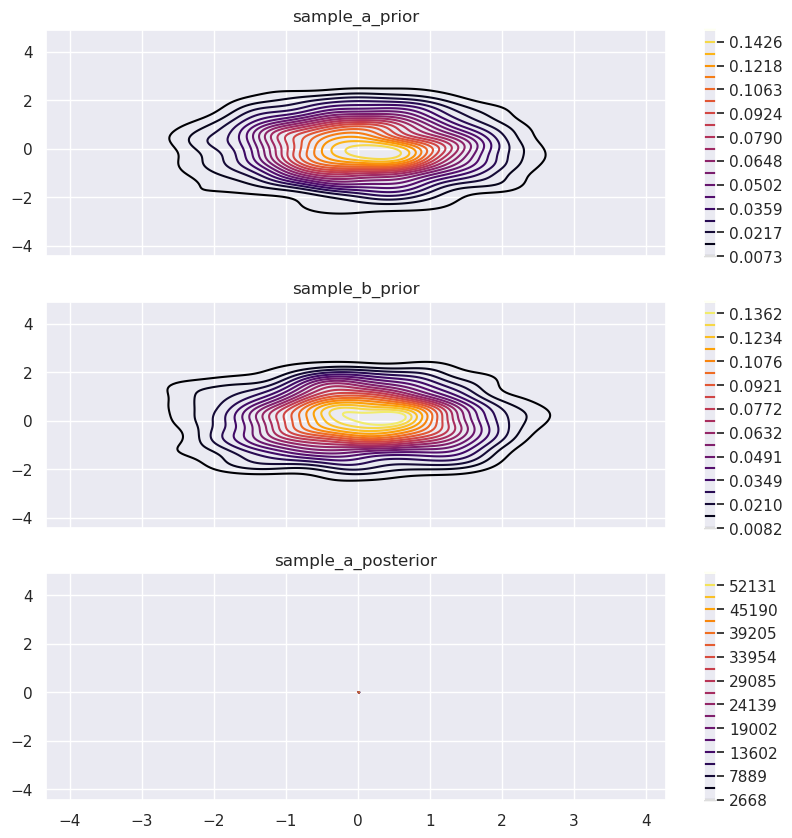

In [12]:
# Visualize the generated prior and posterior samples 
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

sns.kdeplot(x=samples_a_weights_prior[:,0], y=samples_a_weights_prior[:,1], n_levels=20, 
            cmap="inferno", shade=False, cbar=True, ax=axes[0])

sns.kdeplot(x=samples_b_weights_prior[:,0], y=samples_b_weights_prior[:,1], n_levels=20, 
            cmap="inferno", shade=False, cbar=True, ax=axes[1])

sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], n_levels=20, 
            cmap="inferno", shade=False, cbar=True, ax=axes[2])
axes[0].set_title("sample_a_prior")
axes[1].set_title("sample_b_prior")
axes[2].set_title("sample_a_posterior")
plt.show()

#### Comments on the plots
1. In 2d, the posterior samples are quite different from the prior samples 